 <h1><b> Extracción y visualización de datos bursátiles <b></h1> 

###### <i> by: Braulio Herrera G <i>
###### <i> fecha: 01/03/2025 <i>



## Descripción

Este proyecto tiene como objetivo realizar un análisis exploratorio y descriptivo de los precios de cierre mensuales de las acciones de las principales empresas de tecnología: Apple, Microsoft, Google, Amazon, Meta, NVIDIA y Tesla, durante el periodo comprendido entre el 1 de enero de 2023 y el 31 de enero de 2025.

Utilizando herramientas de análisis de datos en Python, como Pandas, Matplotlib, Seaborn y NumPy, se lleva a cabo la limpieza, transformación y visualización de los datos para obtener insights valiosos sobre el comportamiento de los precios y los riesgos asociados a cada empresa.

## Tabla de contenido
#### 1. Configuración del entorno
- Instalación e importación de librerías necesarias (pandas, numpy, matplotlib, seaborn, etc.).
#### 2. Extracción de datos
- Conexión a la API de Alpha Vantage.
- Obtención de los precios de cierre ajustados mensuales (2023-2025).
- Limpieza y preparación de los datos.
#### 3. Análisis exploratorio de datos (EDA)
- Estadísticas descriptivas básicas.
- Distribución de precios por empresa.
- Correlación entre los activos.
#### 4. Análisis de retornos y riesgos
- Cálculo de la volatilidad anualizada por empresa.
- Tendencias y Estacionalidad.
- Variación en los retornos mensuales.
- Coeficiente de variación.
- Visualización de drawdowns.
#### 5. Evaluación de rendimiento
- Cálculo del ratio de Sharpe.
- Cuadro resumen.

#### 6. Simulación Monte Carlo
- Explicación del modelo.
- Gráficos de trayectorias simuladas.
- Tabla resumen con precios proyectados (medio, mínimo, máximo).
#### 7. Resultados y conclusiones
- Resumen de los principales hallazgos.
- Empresas con mejor relación riesgo-retorno.
- Recomendaciones finales basadas en los resultados.

## <h1> 1. Configuración del entorno.<h1>

- Instalación de las librerías necesarias

In [1]:
# %pip install alpha_vantage 
# %pip install pandas 
# %pip install matplotlib 

- Importar las librerías al Jupiter

In [2]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import time
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose

En Python, puedes ignorar las advertencias utilizando el módulo de advertencias. Para eso, usaremos la función filterwarnings para filtrar o ignorar categorías o mensajes de advertencia específicos.

In [3]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## <h1> 2. Extracción de datos.

### Utilizar alphavantage.com para extraer los datos.
Se extraerá los datos de las empresas tecnológicas más grandes del mundo: Apple,  Microsoft, Alphabet (Google), Amazon, Meta (Facebook), NVIDIA, Tesla.

###### <i>**Nota:** indice S&P-500 <i>

*El siguiente código muestra cómo se consultó la API de Alpha Vantage. La gran mayoría de APIs gratuitas como Yahoo Finance (yfinances), alphavantage y otras, tienen un límite en el número de consultas que se pueden realizar. Este límite depende de la cantidad de empresas que quieras consultar y del tipo de datos que necesites extraer. Aunque es posible consultar directamente la API, una forma de evitar bloqueos por exceder el límite de consultas es descargar previamente la información que se va a utilizar. Esto permite un manejo más eficiente de los datos y ayuda a prevenir contratiempos*

In [ ]:
# Tu API Key
api_key = ''# debes ir a la pagina de alpha vantage y registrarse para obtener una key

# Lista de empresas
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']

# DataFrame vacío para almacenar todos los datos
all_data = pd.DataFrame()

# Descargar los datos de cada empresa
for ticker in tickers:
    try:
        ts = TimeSeries(key=api_key, output_format='pandas')
        data, meta_data = ts.get_monthly(symbol=ticker)

        # Filtrar fechas del 2024 al 31/01/2025
        data = data[(data.index >= '2023-01-01') & (data.index <= '2025-01-31')]

        # Asegurarnos de que la columna 'date' sea la columna de índice
        data.reset_index(inplace=True)

        # Renombrar la columna de cierre para identificar cada empresa
        data.rename(columns={'date': 'Date', '4. close': f'{ticker}_close'}, inplace=True)

        # Si es el primer ticker, inicializamos el DataFrame con la fecha
        if all_data.empty:
            all_data['Date'] = data['Date']

        # Añadir los datos de la empresa al DataFrame general
        all_data = pd.merge(all_data, data[['Date', f'{ticker}_Close']], on='Date', how='outer')

        print(f"\nDatos de {ticker} añadidos")

    except Exception as e:
        print(f"Error con {ticker}: {e}")

    # Pausa para evitar llegar al límite de la API
    time.sleep(10)

# Guardar todo el DataFrame combinado en un archivo CSV
all_data.to_csv('acciones_2023_2025.csv', index=False)
print("\nDatos guardados en 'acciones_2023_2025.csv'")

- Una vez descargado al dispositivo local procedemos a cargarlo en pandas para el inicio del análisis:

In [5]:
filepath = r"C:\Users\braul\OneDrive\Escritorio\Proyectos para Github\Final-Assesment.-Stocks-\acciones_2023_2025.csv"
data0 = pd.read_csv(filepath)

## <h1> 3. Análisis exploratorio de datos (EDA) <h1>

In [6]:
data0.head()

,Date,AAPL_Close,MSFT_Close,GOOGL_Close,AMZN_Close,META_Close,NVDA_Close,TSLA_Close
0,31/1/2023,144.29,247.81,98.84,103.13,148.97,19.54,173.22
1,28/2/2023,147.41,249.42,90.06,94.23,174.94,22.33,205.71
2,31/3/2023,164.90,288.30,103.73,103.29,211.94,27.78,207.46
3,28/4/2023,169.68,307.26,107.34,105.45,240.32,27.75,164.31
4,31/5/2023,177.25,328.39,122.87,120.58,264.72,37.83,203.93


- Renombrar las columnas con el nombre de las empresas

In [7]:
nuevos_nombres = {
    'AAPL_Close': 'Apple_Inc',
    'MSFT_Close': 'Microsoft_Co',
    'GOOGL_Close': 'Google_Alphabet',
    'AMZN_Close': 'Amazon_Inc',
    'META_Close': 'Meta_Platforms',
    'NVDA_Close': 'Nvidia_Corp',
    'TSLA_Close': 'Tesla_Inc'
}

# Renombrar las columnas
data_original = data0.rename(columns=nuevos_nombres)

- Estadísticas descriptivas básicas

In [8]:
data_original.describe()

,Apple_Inc,Microsoft_Co,Google_Alphabet,Amazon_Inc,Meta_Platforms,Nvidia_Corp,Tesla_Inc
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,193.994000,369.988800,144.786400,157.886800,399.087600,75.516000,236.679600
std,29.207287,57.853699,29.708252,38.701724,145.563079,41.190397,64.609353
min,144.290000,247.810000,90.060000,94.230000,148.970000,19.540000,164.310000
25%,171.210000,328.390000,124.080000,130.360000,295.890000,42.300000,197.880000
50%,189.950000,389.330000,139.690000,155.200000,390.140000,61.520000,214.110000
75%,222.080000,417.140000,168.950000,186.330000,504.220000,119.370000,258.080000
max,250.420000,446.950000,204.020000,237.680000,689.180000,138.250000,404.600000


- Distribución de los Precios por empresa

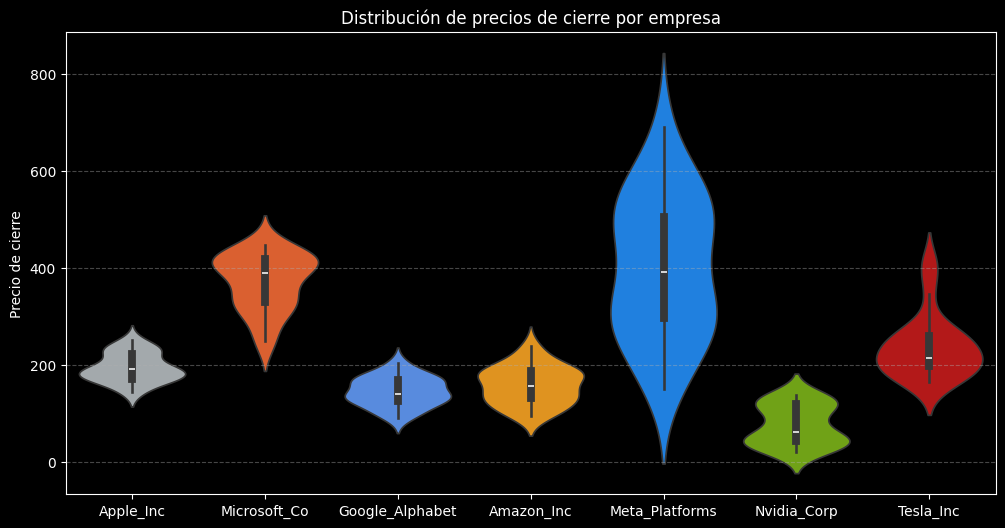

In [9]:
plt.figure(figsize=(12, 6))
# colores segun los logos de las empresas
colores = ['#A2AAAD', '#F65314', '#4285F4', '#FF9900', '#0080FF', '#76B900', '#CC0000']
sns.violinplot(data=data_original, palette=colores)
plt.title('Distribución de precios de cierre por empresa', color='white')
plt.ylabel('Precio de cierre', color='white')
plt.xticks(color='white') 
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tick_params(axis='both', colors='white')
# bordes de la grafica
ax = plt.gca() 
for spine in ax.spines.values():
    spine.set_color('white')
    
plt.show()

- Resumen Gráfico de las Series Temporales

Gráfico de líneas: Muestra cómo han cambiado los precios de cierre de cada acción a lo largo del tiempo.

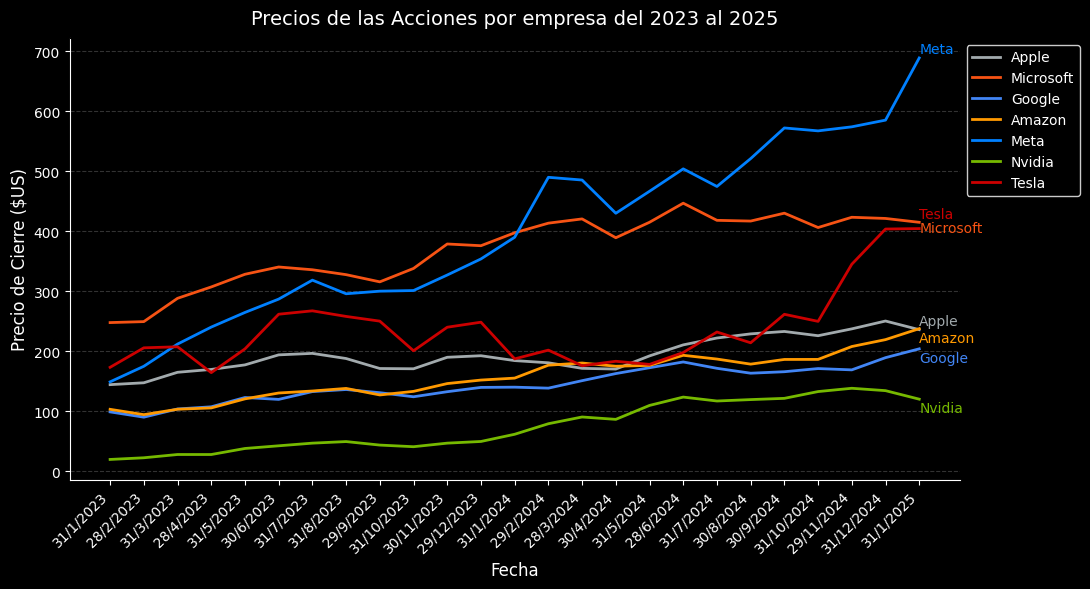

In [10]:
plt.figure(figsize=(11, 6))
# Graficar las series de tiempo
plt.plot(data_original['Date'], data_original['Apple_Inc'], label='Apple', color='#A2AAAD', linewidth=2)
plt.plot(data_original['Date'], data_original['Microsoft_Co'], label='Microsoft', color='#F65314', linewidth=2)
plt.plot(data_original['Date'], data_original['Google_Alphabet'], label='Google', color='#4285F4', linewidth=2)
plt.plot(data_original['Date'], data_original['Amazon_Inc'], label='Amazon', color='#FF9900', linewidth=2)
plt.plot(data_original['Date'], data_original['Meta_Platforms'], label='Meta', color='#0080FF', linewidth=2)
plt.plot(data_original['Date'], data_original['Nvidia_Corp'], label='Nvidia', color='#76B900', linewidth=2)
plt.plot(data_original['Date'], data_original['Tesla_Inc'], label='Tesla', color='#CC0000', linewidth=2)

# definir los limites de los ejes
def agregar_etiqueta_final(x, y, nombre, color, desplazamiento=0):
    plt.text(x.iloc[-1], y.iloc[-1] + desplazamiento, nombre, color=color, 
             fontsize=10, ha='left', va='center')

# Ajustar los desplazamientos
fechas = data_original['Date']
agregar_etiqueta_final(fechas, data_original['Apple_Inc'], 'Apple', '#A2AAAD', desplazamiento=15)
agregar_etiqueta_final(fechas, data_original['Microsoft_Co'], 'Microsoft', '#F65314', desplazamiento=-10)
agregar_etiqueta_final(fechas, data_original['Google_Alphabet'], 'Google', '#4285F4', desplazamiento=-15)
agregar_etiqueta_final(fechas, data_original['Amazon_Inc'], 'Amazon', '#FF9900', desplazamiento=-15)
agregar_etiqueta_final(fechas, data_original['Meta_Platforms'], 'Meta', '#0080FF', desplazamiento=15)
agregar_etiqueta_final(fechas, data_original['Nvidia_Corp'], 'Nvidia', '#76B900', desplazamiento=-15)
agregar_etiqueta_final(fechas, data_original['Tesla_Inc'], 'Tesla', '#CC0000', desplazamiento=25)

# ajustes del grafico
plt.xlabel('Fecha', color='white', fontsize=12)
plt.ylabel('Precio de Cierre ($US)', color='white', fontsize=12)
plt.title('Precios de las Acciones por empresa del 2023 al 2025', color='white', fontsize=14, pad=10)
plt.legend(bbox_to_anchor=(1, 1), facecolor='black', edgecolor='white', labelcolor='white',fontsize=10)
# Configurar el fondo y los colores de los ejes
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.grid(axis='y', linestyle='--', alpha=0.2, color='white')
# Configurar los ticks y las líneas de los ejes
plt.tick_params(axis='both', colors='white', labelsize=10)
ax = plt.gca()
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Rotar las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=45, ha='right', fontsize=10)
# Ajustar el layout para que no se corten las etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

- Correlaciones entre las empresas


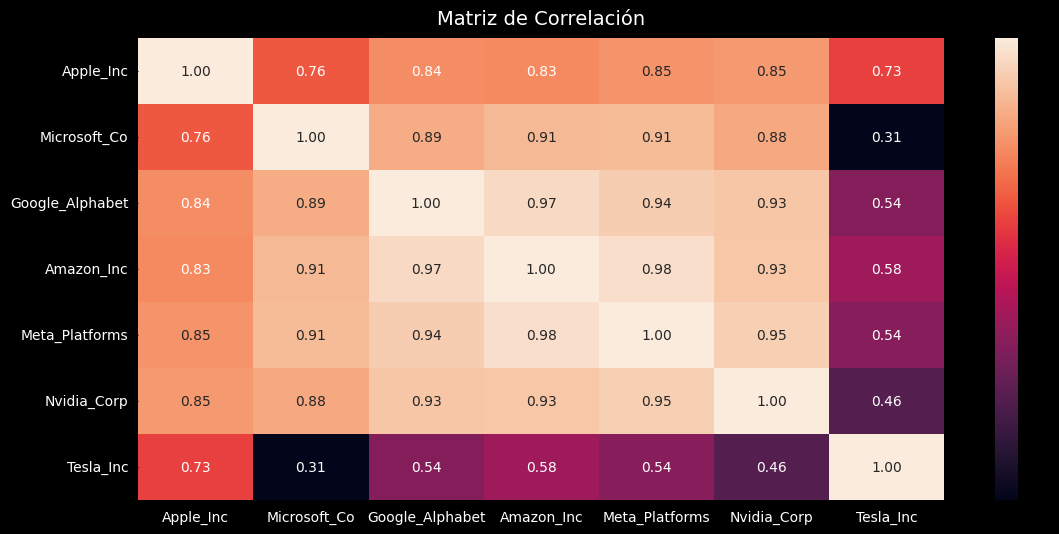

In [11]:
df = data_original[['Apple_Inc', 'Microsoft_Co', 'Google_Alphabet', 'Amazon_Inc', 'Meta_Platforms', 'Nvidia_Corp', 'Tesla_Inc']]
correlation_matrix = df.corr()

# Visualizar el heatmap
plt.figure(figsize=(13, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.2f')
plt.title('Matriz de Correlación', color = 'white', fontsize=14, pad=10)
plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')  
plt.xticks(color='white')
plt.yticks(color='white')  
ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_color('white')

plt.show()

## <h1> 4. Análisis de retornos y riesgos. <h1>

#### Volatilidad

La volatilidad del precio de una acción es una medida estadística que indica la variabilidad o fluctuación del precio de una acción en un período de tiempo determinado. Se utiliza para evaluar el riesgo asociado con la inversión en esa acción, ya que una mayor volatilidad implica que el precio puede cambiar significativamente en poco tiempo, lo que puede resultar en ganancias o pérdidas potenciales más grandes.

In [12]:
# Calcular retornos mensuales
returns = df.pct_change()
# Calcular volatilidad (desviación estándar de los retornos)
volatility = returns.std() * np.sqrt(12) # anualizada
print(volatility*100)  

Apple_Inc          20.636007
Microsoft_Co       19.757904
Google_Alphabet    22.963097
Amazon_Inc         21.767931
Meta_Platforms     30.939375
Nvidia_Corp        44.700444
Tesla_Inc          56.060775
dtype: float64


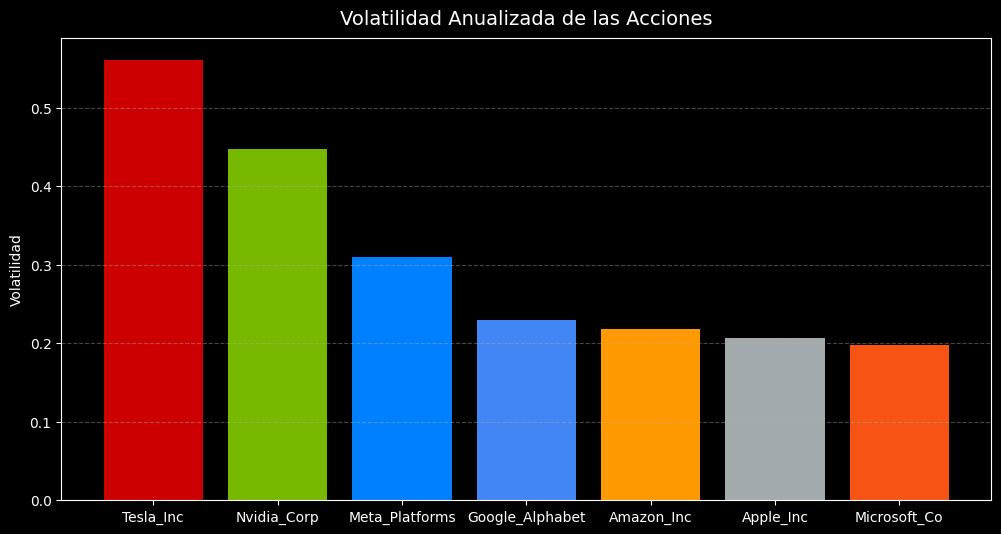

In [13]:
volatility_sorted = volatility.sort_values(ascending=False)
colores = ['#CC0000','#76B900','#0080FF', '#4285F4', '#FF9900','#A2AAAD', '#F65314']
# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(volatility_sorted.index, volatility_sorted, color=colores)
plt.title('Volatilidad Anualizada de las Acciones', color='white', fontsize=14, pad=10)
plt.ylabel('Volatilidad', color='white')
plt.xticks(rotation=360, fontsize=10 , color='white')
plt.yticks(color='white')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tick_params(axis='both', colors='white')
ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_color('white')

plt.gcf().set_facecolor('black')
plt.gca().set_facecolor('black')
plt.show()

### Análisis de tendencias y patrones

En esta sección, se realiza un análisis de tendencias en los precios de cierre mensuales de las principales empresas tecnológicas para identificar comportamientos a lo largo del tiempo y posibles patrones recurrentes. Para ello, se implementan los siguientes enfoques:

**Medias Móviles (Moving Averages)**: Se calculan medias móviles simples (SMA) de 3 y 6 meses para suavizar la serie temporal, lo que permite visualizar la tendencia subyacente eliminando fluctuaciones de corto plazo. Esta técnica es útil para identificar momentos de alza o baja sostenida en los precios de las acciones.

**Descomposición de Series Temporales (Time Series Decomposition)**: Se utiliza la descomposición aditiva para separar cada serie temporal en sus componentes principales:

- **Tendencia**: La dirección general del precio a lo largo del tiempo.
- **Estacionalidad**: Fluctuaciones periódicas que se repiten en intervalos regulares.

Se elige estos modelos porque son herramientas interpretables y efectivas para explorar series temporales financieras, proporcionando insights claros sobre la evolución del valor de las acciones y ayudando a anticipar posibles comportamientos futuros.

**Primer paso**

Con el Objetivo de optimizar el código y reducir las redundancias de código se usaran definiciones donde incluirá los siguientes parámetros:
- data: DataFrame con los datos.
- data_resumen: Una copia del df original.
- columna_empresa: Nombre de la columna que contiene los datos de la empresa.
- ventana: Tamaño de la ventana para la media móvil (por defecto 3)
- color_linea: Color de la línea en el gráfico (por defecto 'blue').
- color_fondo: Color de fondo del gráfico (por defecto 'black').
- titulo: Título personalizado para el gráfico.

In [14]:
def grafico_media_movil(data, columna_empresa, ventana=3, color_linea='blue', color_fondo='black', titulo=None):
   
    # Trabajar con una copia del DataFrame para no modificar el original
    data_resumen = data.copy()
    
    # Calcular la media móvil
    data_resumen[f'{columna_empresa}_MA'] = data_resumen[columna_empresa].rolling(window=ventana).mean()

    # Graficar
    ax = data_resumen[['Date', columna_empresa, f'{columna_empresa}_MA']].set_index('Date').plot(
        figsize=(12, 6), 
        title= titulo,
        color=[color_linea, 'white']
    )
    # Personalizar el gráfico
    plt.legend(facecolor=color_fondo, edgecolor='white', labelcolor='white')
    plt.title(titulo, color='white')
    plt.gcf().set_facecolor(color_fondo)
    plt.gca().set_facecolor(color_fondo)
    plt.grid(axis='y', linestyle='--', alpha=0.3) 
    plt.xticks(color='white')
    plt.yticks(color='white')
    plt.xlabel('Fecha', color='white')
    for spine in ax.spines.values():
        spine.set_color('white')
        
    plt.show()

**Segundo Paso**

Definir la función para la descompoción de series de tiempo, parámetros:
- data: DataFrame con los datos.
- columna_empresa: Nombre de la columna que contiene los datos de la empresa.
- modelo: Tipo de modelo de descomposición (multiplicative).
- periodo: Período para la descomposición (por defecto 12).
- color_fondo: Color de fondo del gráfico (por defecto 'black').

In [15]:
def grafico_descomposicion(data, columna_empresa, modelo='multiplicative', periodo=12, color_fondo='black'):
    # trabajar con una copia del DataFrame para no modificar el original
    data_resumen = data.copy()
    
    # Asegurarse de que el DataFrame esté indexado por la columna 'Date'
    if 'Date' in data_resumen.columns:
        data_resumen.set_index('Date', inplace=True)

    # Descomposición de series temporales
    decomposition = seasonal_decompose(data_resumen[columna_empresa], model=modelo, period=periodo)

    # Crear subplots para la descomposición
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Graficar cada componente de la descomposición
    decomposition.trend.plot(ax=axes[0], title='Tendencia', color='blue')
    decomposition.seasonal.plot(ax=axes[1], title='Estacionalidad', color='blue')

    # Personalizar cada subplot
    for ax, title in zip(axes, ['Tendencia', 'Estacionalidad']):
        ax.set_facecolor(color_fondo)
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.set_xlabel('Fecha', color='white')
        ax.set_title(title, color='white')
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        for spine in ax.spines.values():
            spine.set_color('white')
        
    plt.gcf().set_facecolor(color_fondo)
    plt.tight_layout()
    plt.show()

### Análisis de Tendencias

- Se comenzará con **Tesla Inc**

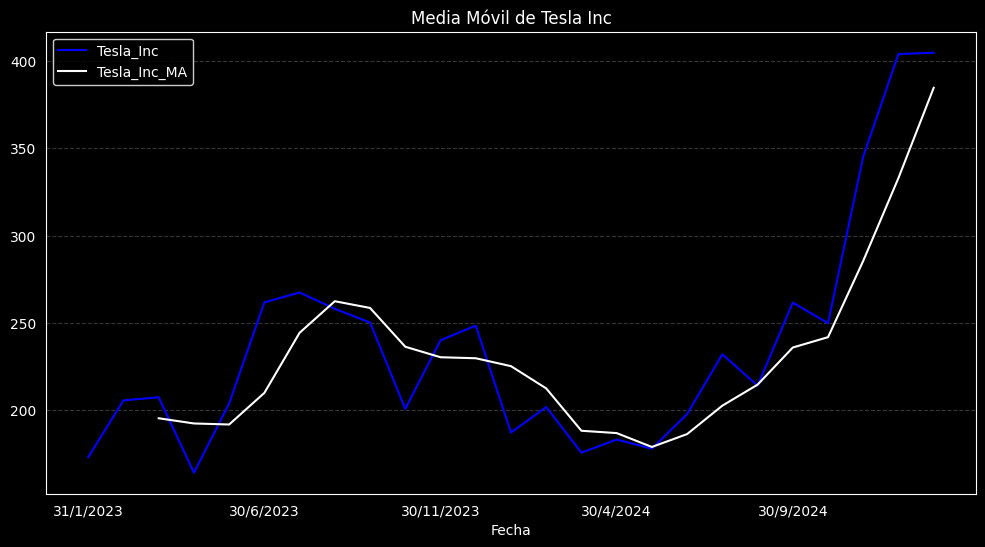

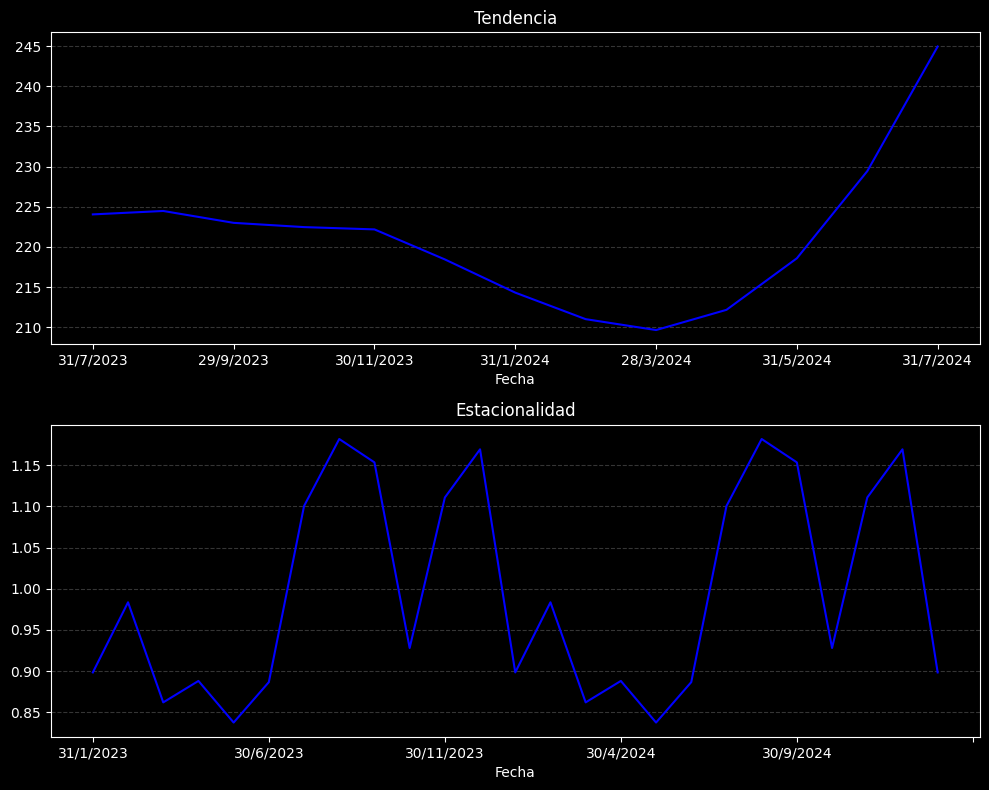

In [16]:
# Graficar Tesla
grafico_media_movil(data_original, columna_empresa='Tesla_Inc', titulo='Media Móvil de Tesla Inc')
grafico_descomposicion(data_original, columna_empresa='Tesla_Inc')

- Análisis **Apple Inc**

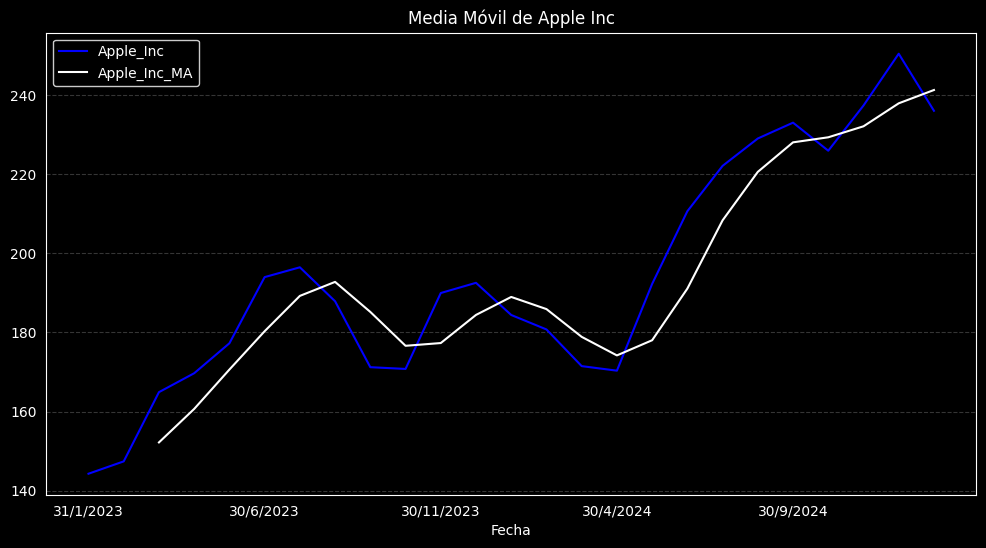

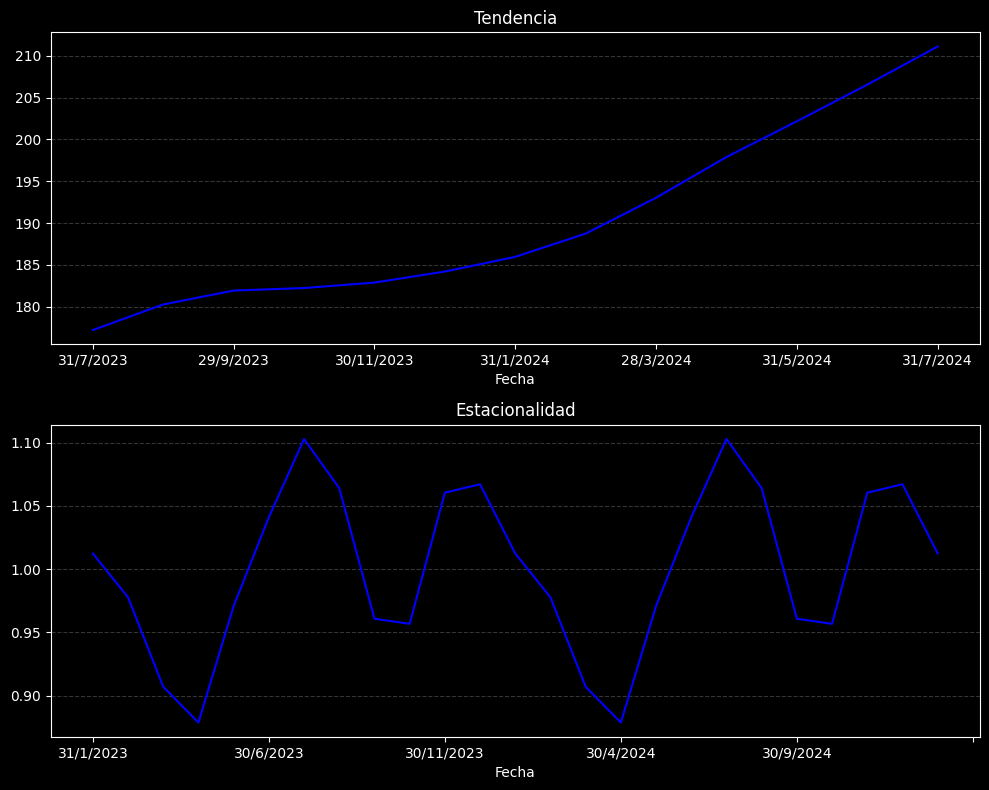

In [17]:
grafico_media_movil(data_original, columna_empresa='Apple_Inc', titulo='Media Móvil de Apple Inc')
grafico_descomposicion(data_original, columna_empresa='Apple_Inc')

- Análisis **Nvidia Corp**

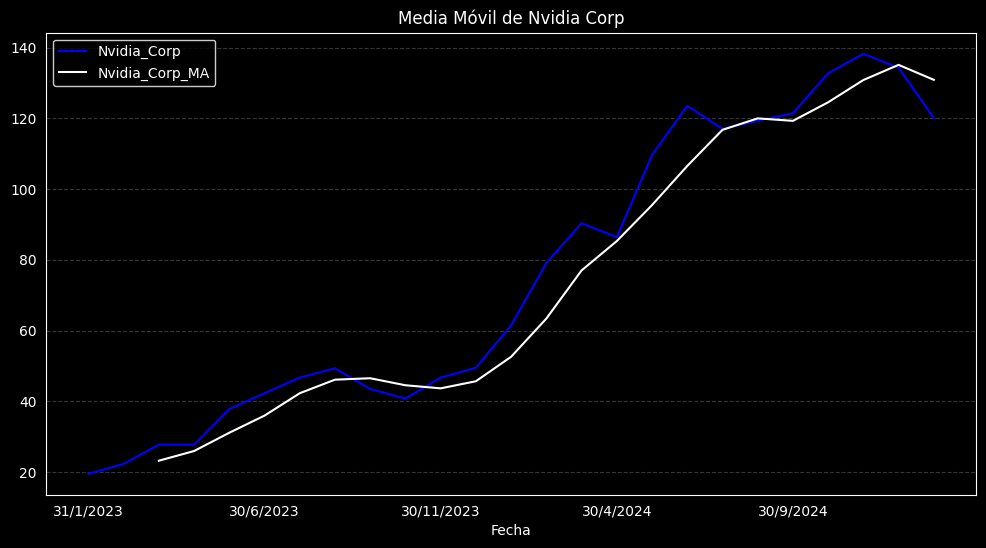

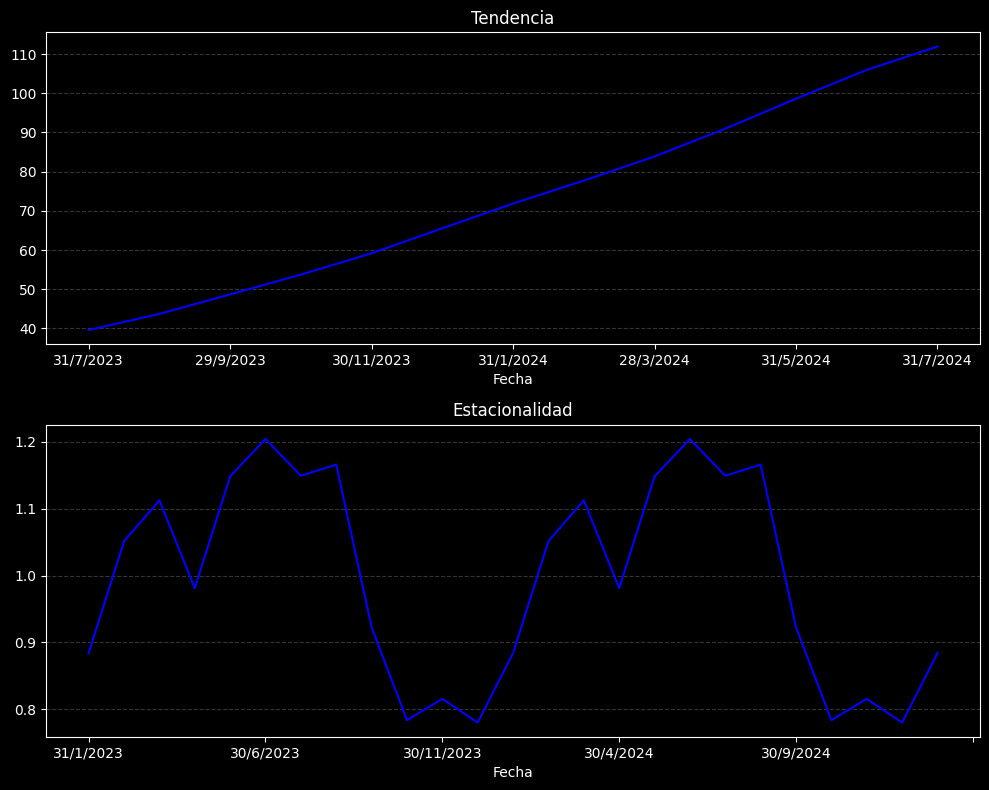

In [18]:
grafico_media_movil(data_original, columna_empresa='Nvidia_Corp', titulo='Media Móvil de Nvidia Corp')
grafico_descomposicion(data_original, columna_empresa='Nvidia_Corp')

- Análisis **Meta Platforms**

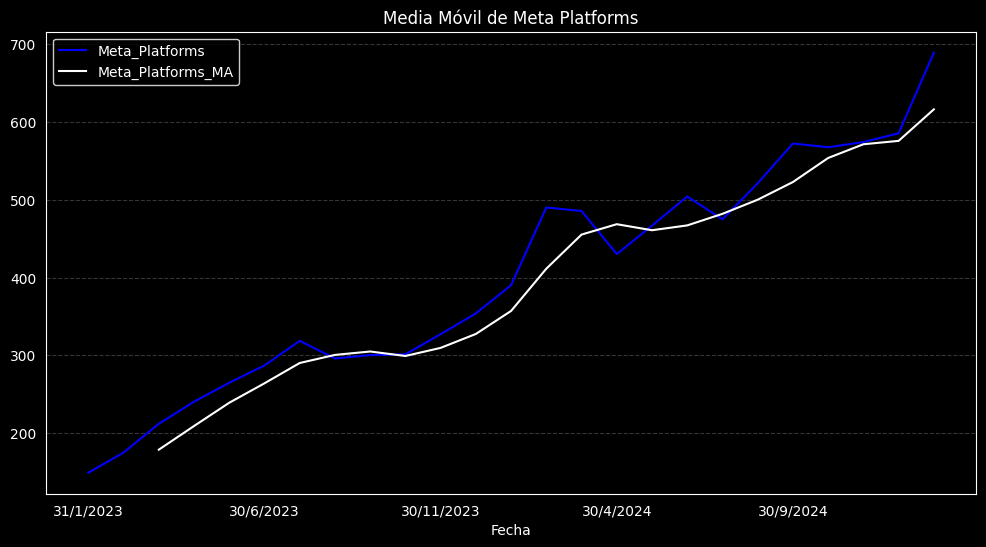

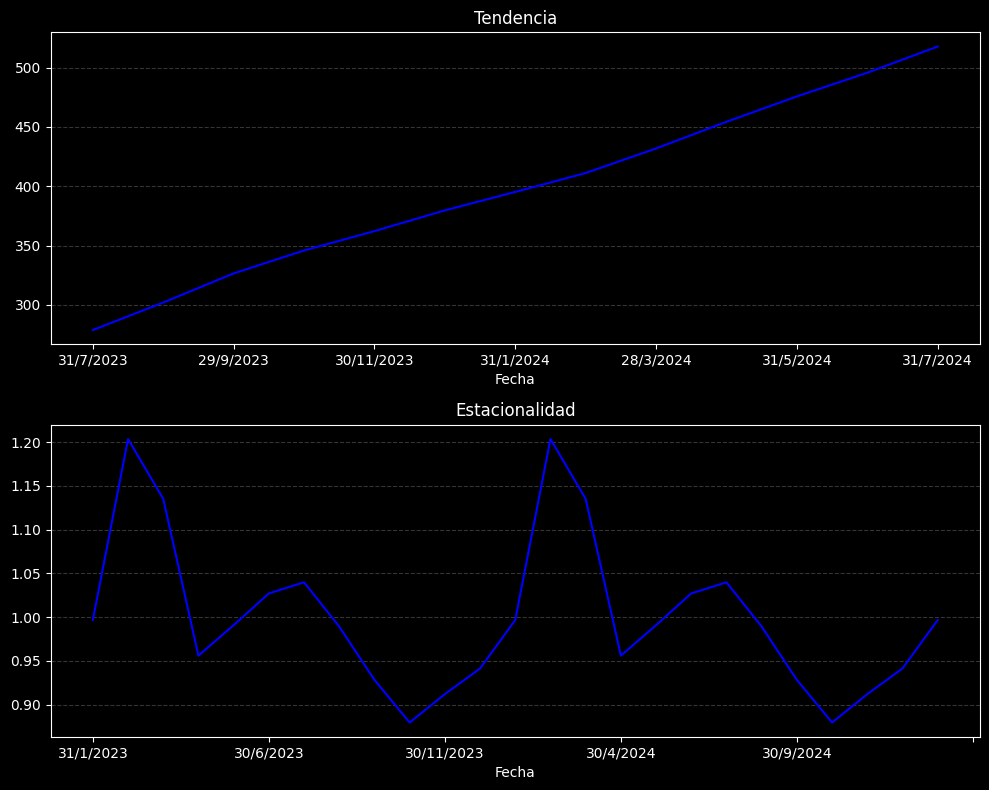

In [19]:
grafico_media_movil(data_original, columna_empresa='Meta_Platforms', titulo='Media Móvil de Meta Platforms')
grafico_descomposicion(data_original, columna_empresa='Meta_Platforms')

- Análisis de **Amazon Inc**

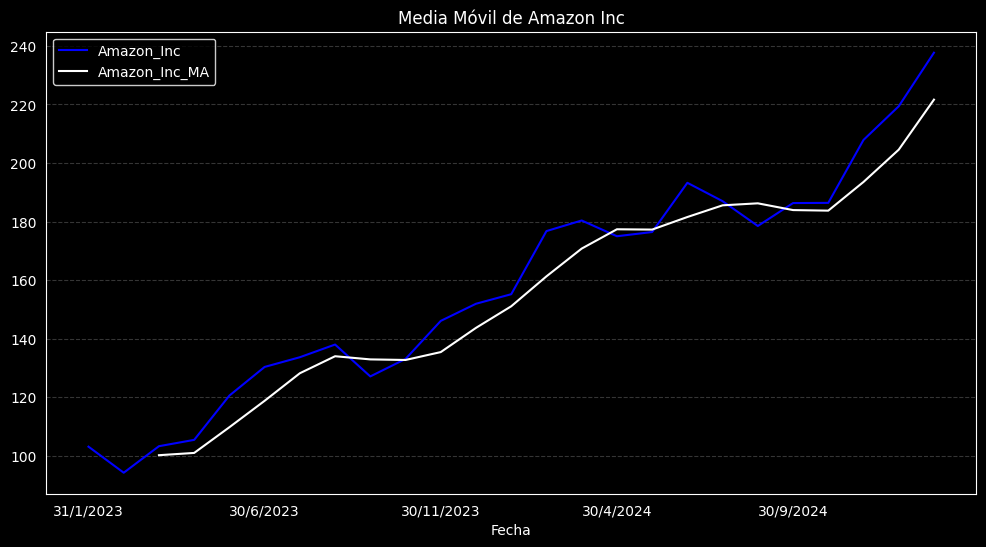

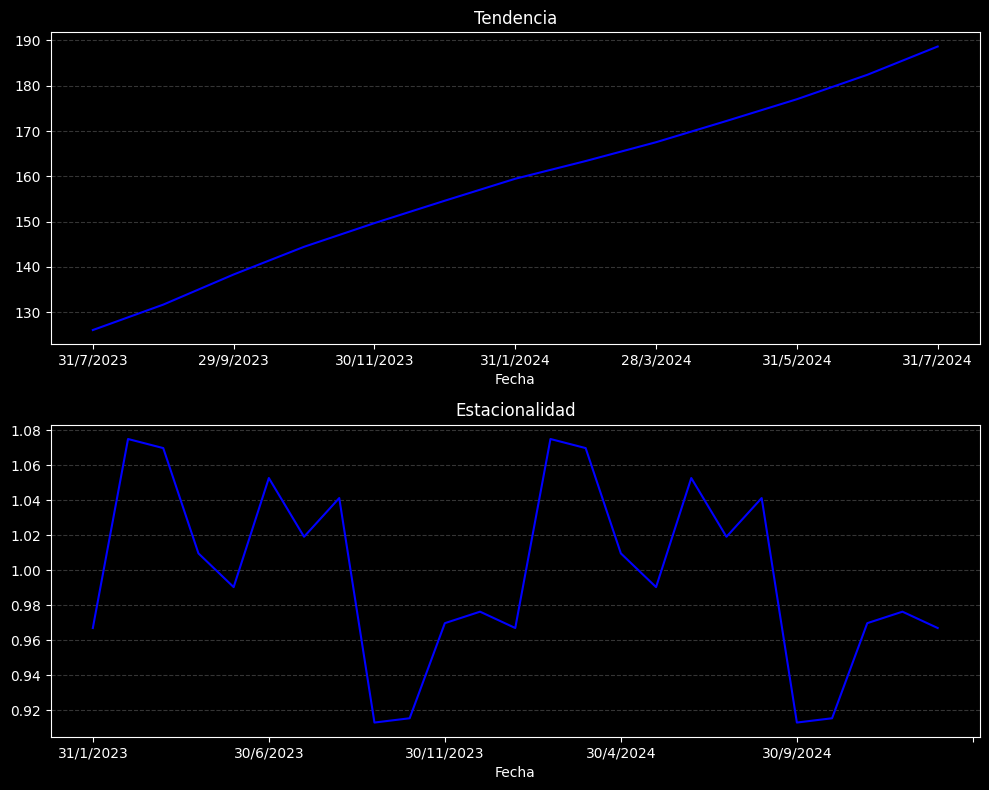

In [20]:
grafico_media_movil(data_original, columna_empresa='Amazon_Inc', titulo='Media Móvil de Amazon Inc')
grafico_descomposicion(data_original, columna_empresa='Amazon_Inc')

#### Análisis de Retornos

El análisis de retornos por el método logarítmico es esencial para comprender la rentabilidad de las acciones y evaluar el comportamiento de los precios a lo largo del tiempo. A diferencia de los retornos simples, los retornos logarítmicos son simétricos, lo que facilita la comparación entre diferentes periodos y permite analizar las variaciones porcentuales de manera más precisa.

En este análisis, se evalúan los retornos logarítmicos mensuales de cada empresa para identificar patrones de crecimiento, medir la volatilidad y detectar posibles cambios estructurales en las series temporales. Esta perspectiva proporciona información valiosa para evaluar la estabilidad del mercado y tomar decisiones informadas sobre las tendencias de cada activo.

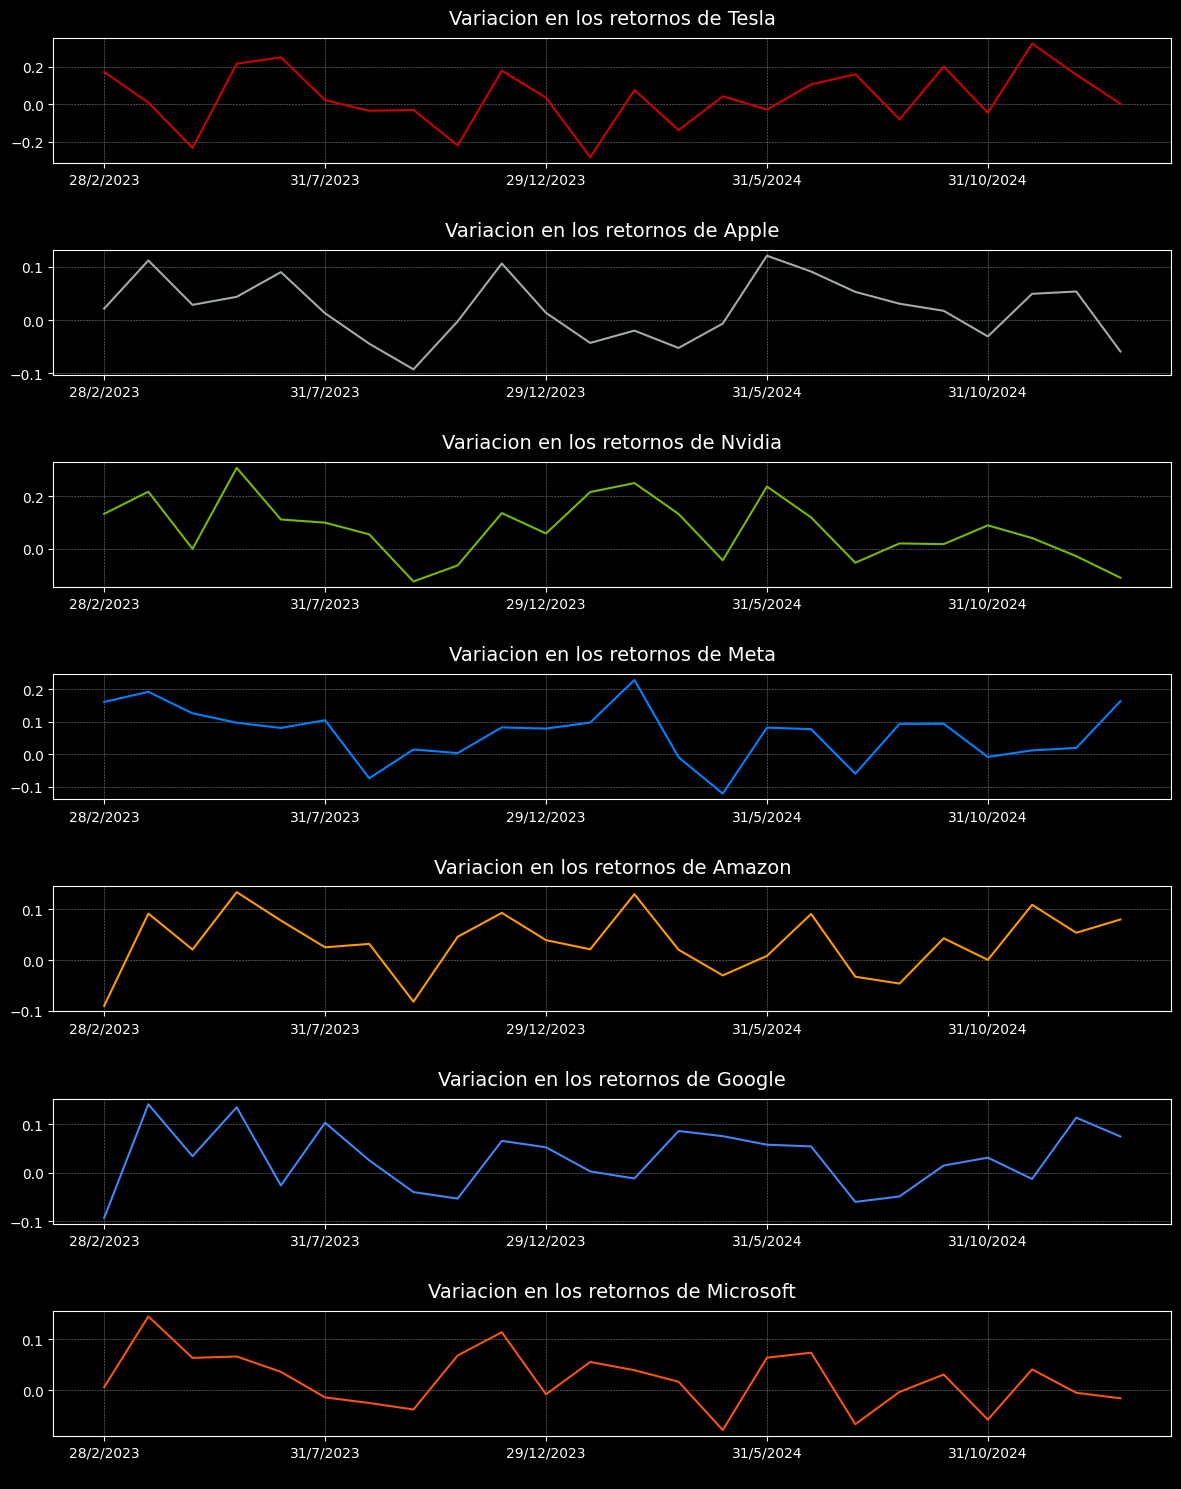

In [21]:
# Función para personalizar el gráfico
def personalizar_grafico(ax, titulo):
    ax.set_facecolor('black')  
    ax.set_title(titulo, color='white', fontsize=14, pad=10)
    ax.grid(color='gray', linestyle='--', linewidth=0.4)
    ax.tick_params(colors='white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.xaxis.label.set_color('white')

# Lista de empresas y sus columnas correspondientes
empresas2 = {
    'Tesla_Inc': 'Tesla_Log_Return',
    'Apple_Inc': 'Apple_Log_Return',
    'Nvidia_Corp': 'Nvidia_Log_Return',
    'Meta_Platforms': 'Meta_Log_Return',
    'Amazon_Inc': 'Amazon_Log_Return',
    'Google_Alphabet': 'Google_Log_Return',
    'Microsoft_Co': 'Microsoft_Log_Return'
}
# crear una copia del DataFrame original	
data_resumen = data_original.copy() 

if 'Date' in data_resumen.columns:
    data_resumen.set_index('Date', inplace=True)
    
# Calcular los retornos logarítmicos para todas las empresas
for empresa, columna in empresas2.items():
    data_resumen[columna] = np.log(data_resumen[empresa] / data_resumen[empresa].shift(1))
    
data_resumen.dropna(inplace=True)
# Visualizar los retornos
fig, axes = plt.subplots(len(empresas2), 1, figsize=(12, 15))

# Colores para cada gráfico
colores = ['#CC0000', '#A2AAAD', '#76B900', '#0080FF', '#FF9900', '#4285F4', '#F65314']

# Graficar los retornos logarítmicos para cada empresa
for i, ((empresa, columna), color) in enumerate(zip(empresas2.items(), colores)):
    data_resumen[columna].plot(ax=axes[i], color=color, title=f'Variación en los retornos de {empresa.split("_")[0]}')
    personalizar_grafico(axes[i], f'Variacion en los retornos de {empresa.split("_")[0]}')
    axes[i].set_xlabel('Fecha', color='black') 
# Ajustar el layout
plt.gcf().set_facecolor('black')
plt.tight_layout()
plt.show()

#### Coeficiente de Variación

El coeficiente de variación (CV) mide la dispersión de un conjunto de datos en relación con su media

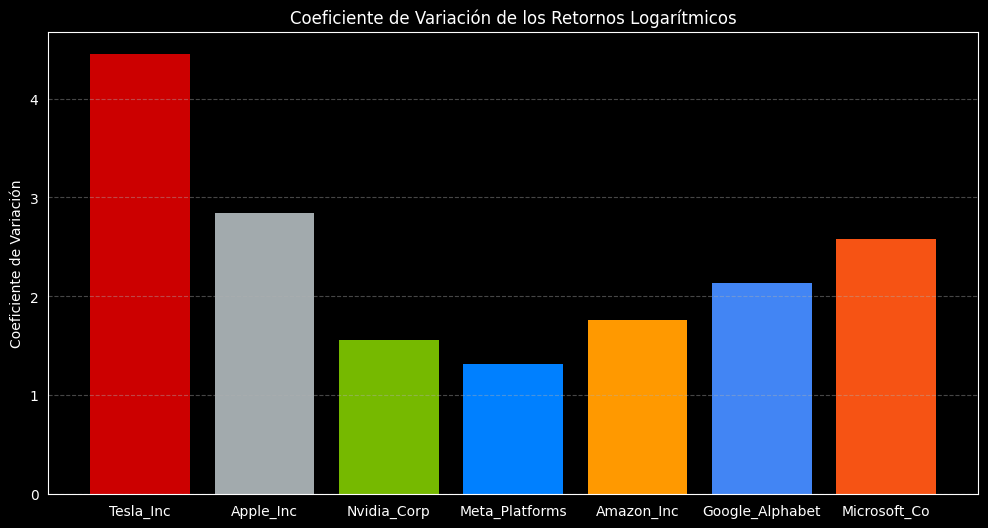

In [22]:
# Coeficiente de variación
cv = {empresa: data_resumen[columna].std() / data_resumen[columna].mean() for empresa, columna in empresas2.items()}
colores = ['#CC0000', '#A2AAAD', '#76B900', '#0080FF', '#FF9900', '#4285F4', '#F65314'] # colores segun los logos de las empresas
plt.figure(figsize=(12, 6))
plt.bar(cv.keys(), cv.values(), color=colores)
plt.ylabel('Coeficiente de Variación', color='white')
plt.title('Coeficiente de Variación de los Retornos Logarítmicos', color='white')
plt.xticks(color='white')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.yticks(color='white')
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')
for ax in plt.gca().spines.values():
    ax.set_color('white')
plt.show()

**Visualización de drawdown**

El drawdown mide las caídas desde un pico hasta un valle en el valor de un activo. Es decir, indica cuánto ha caído el precio de la acción desde su punto más alto antes de recuperarse.
El máximo drawdown (MDD) es la caída más grande registrada durante un período, y se usa para evaluar el riesgo:

Drawdown grande → Más riesgo y volatilidad.
Drawdown pequeño → Menor riesgo y más estabilidad.

En términos simples, te dice cuál ha sido la peor pérdida relativa que podrías haber experimentado si hubieras comprado en el punto más alto y vendido en el punto más bajo.

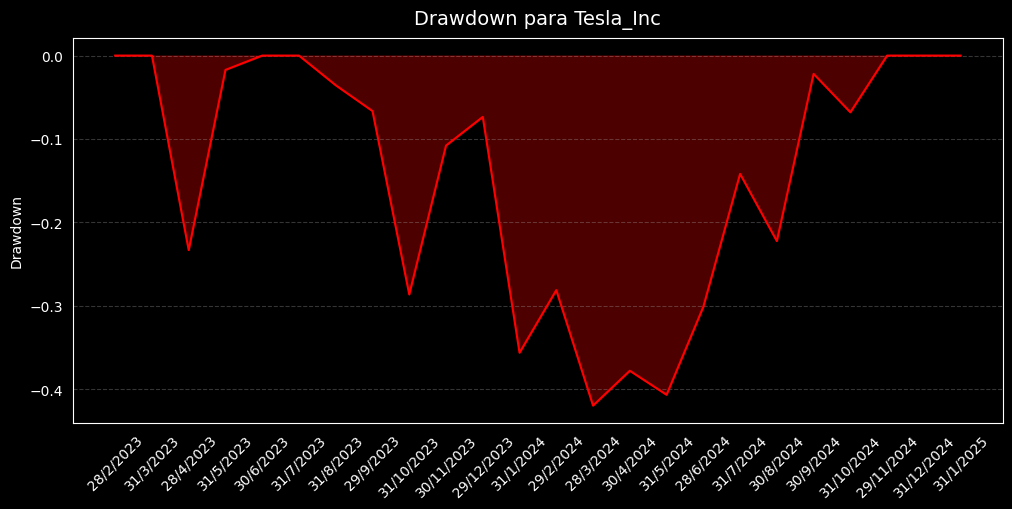

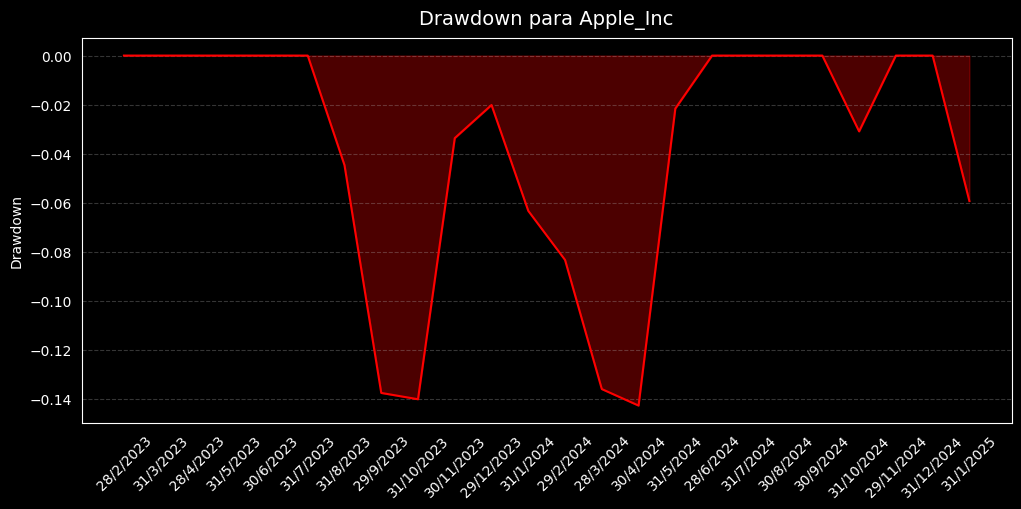

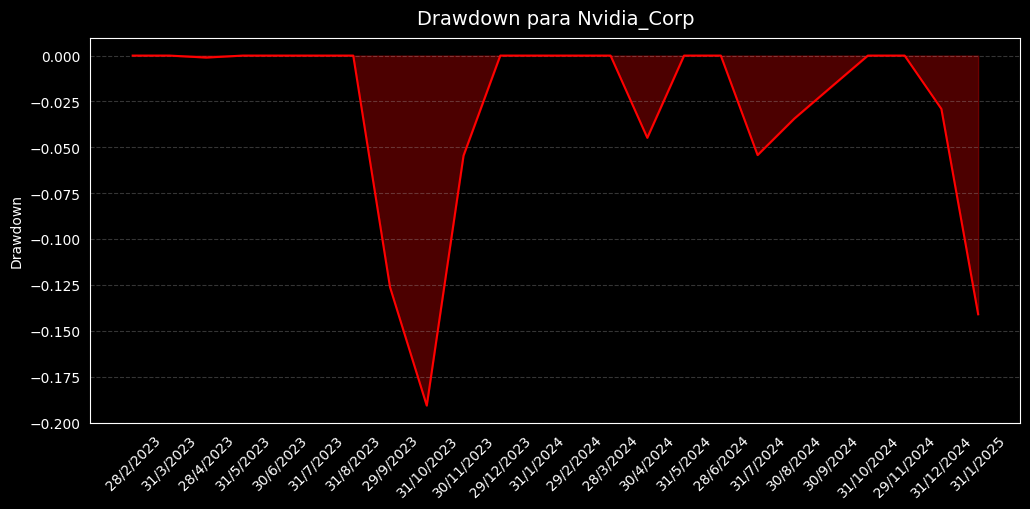

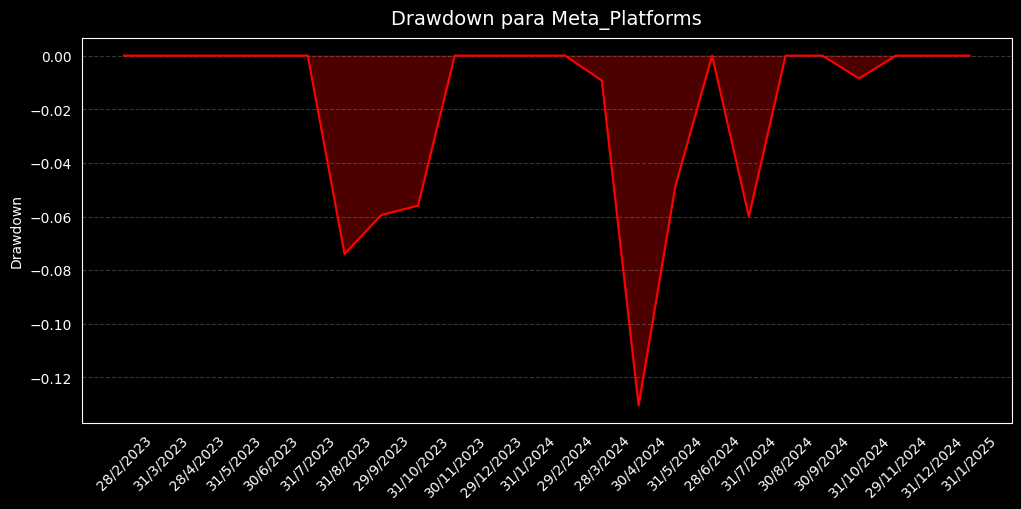

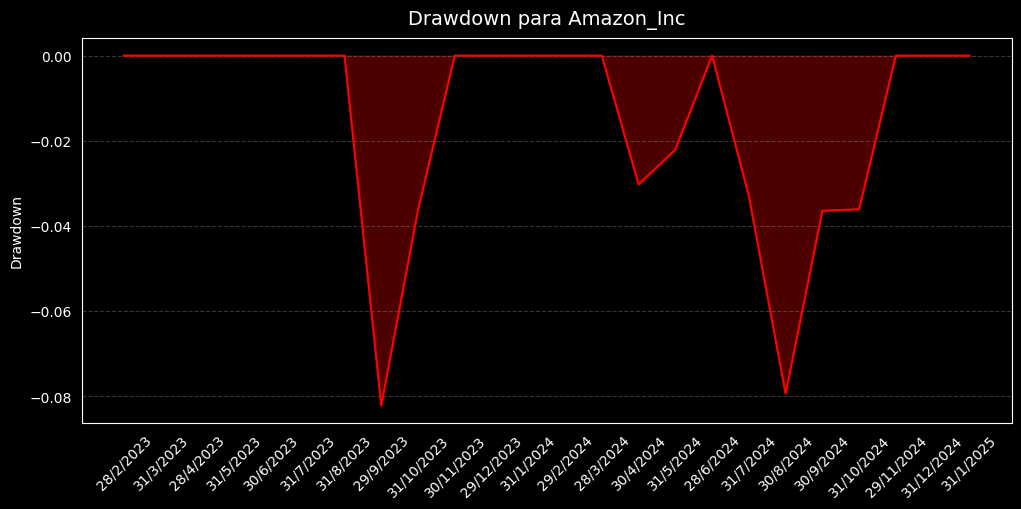

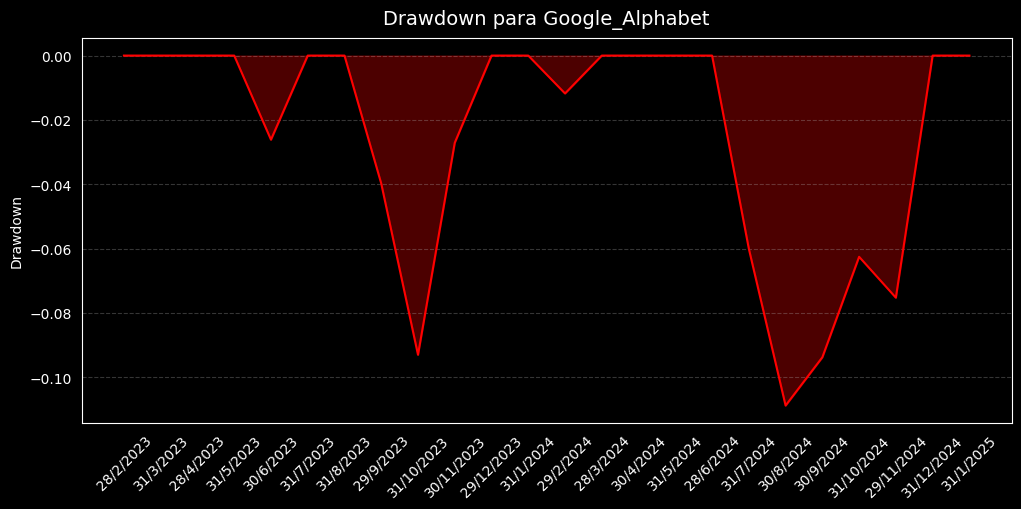

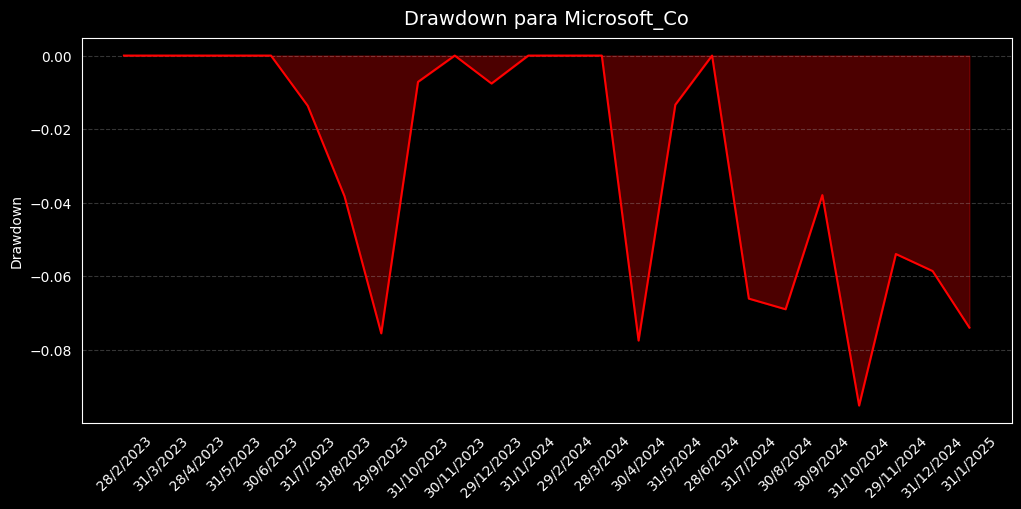

In [23]:
# Drawdown máximo
drawdowns = {}

for empresa, columna in empresas2.items():
    acumulado = data_resumen[columna].cumsum()
    max_pico = acumulado.cummax()
    drawdown = (acumulado - max_pico)
    max_drawdown = drawdown.min()
    drawdowns[empresa] = max_drawdown

    plt.figure(figsize=(12, 5)) 
    plt.plot(drawdown, label=f'{empresa} Drawdown', color='red')
    plt.fill_between(drawdown.index, drawdown, color='red', alpha=0.3)
    plt.ylabel('Drawdown', color='white')
    plt.title(f'Drawdown para {empresa}', color='white', fontsize=14, pad=10)
    plt.gca().set_facecolor('black')
    plt.gcf().set_facecolor('black')
    plt.xticks(rotation=45, color='white', size=10)
    plt.yticks(color='white')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    for ax in plt.gca().spines.values():
        ax.set_color('white')
    
plt.show()

## <h1> 5. Evaluación de rendimiento. <h1>

#### Ratio de Sharpe
El ratio de Sharpe es una herramienta financiera que mide la relación entre la rentabilidad y el riesgo de una inversión. Sirve para evaluar si los rendimientos de una inversión son proporcionales al riesgo asumido

In [24]:
# Parámetros
risk_free_rate = 0.0409 # Tasa libre de riesgo

# Calcular el ratio de Sharpe y graficar la distribución de retornos
sharpe_ratios = {}

for empresa, columna in empresas2.items():
    # Calcular el ratio de Sharpe
    mean_return = data_resumen[columna].mean()
    volatility = data_resumen[columna].std()
    sharpe_ratio = (mean_return - risk_free_rate) / volatility
    sharpe_ratios[empresa] = sharpe_ratio

    # Mostrar el ratio de Sharpe
    print(f"Ratio de Sharpe para {empresa}: {sharpe_ratio:.4f}")

Ratio de Sharpe para Tesla_Inc: -0.0353
Ratio de Sharpe para Apple_Inc: -0.3503
Ratio de Sharpe para Nvidia_Corp: 0.2950
Ratio de Sharpe para Meta_Platforms: 0.2720
Ratio de Sharpe para Amazon_Inc: -0.0999
Ratio de Sharpe para Google_Alphabet: -0.1664
Ratio de Sharpe para Microsoft_Co: -0.3499


#### Cuadro de comparación de empresas

In [25]:
resultados = pd.DataFrame({
    'Empresa': list(empresas2.keys()),
    'Retorno Medio Mensual (%)': [data_resumen[col].mean() * 100 for col in empresas2.values()],
    'Volatilidad Mensual (%)': [data_resumen[col].std() * 100 for col in empresas2.values()],
    'Drawdown Máximo (%)': [drawdowns[empresa] * 100 for empresa in empresas2.keys()],
    'Ratio de Sharpe': [sharpe_ratios[empresa] for empresa in empresas2.keys()]
}).sort_values('Ratio de Sharpe', ascending=False)  
# Ajustar los nombres para que se vean más limpios
resultados['Empresa'] = resultados['Empresa'].str.replace('_', ' ')

# Redondear los valores para mejorar la visualización
resultados = resultados.round(2)
resultados = resultados.reset_index(drop=True)
# crear un DataFrame de resumen
resumen_resultados = resultados.copy()
# Mostrar los resultados
resumen_resultados

,Empresa,Retorno Medio Mensual (%),Volatilidad Mensual (%),Drawdown Máximo (%),Ratio de Sharpe
0,Nvidia Corp,7.57,11.78,-19.07,0.30
1,Meta Platforms,6.38,8.43,-13.05,0.27
2,Tesla Inc,3.53,15.72,-41.96,-0.04
3,Amazon Inc,3.48,6.12,-8.22,-0.10
4,Google Alphabet,3.02,6.43,-10.88,-0.17
5,Microsoft Co,2.15,5.55,-9.52,-0.35
6,Apple Inc,2.05,5.82,-14.27,-0.35


## <h1> 6. Simulación de Monte Carlo. <h1>

En esta sección, se realiza una simulación de Monte Carlo para proyectar los posibles precios futuros de las acciones de las principales empresas tecnológicas analizadas. Esta técnica permite modelar múltiples trayectorias posibles del precio de una acción, considerando su comportamiento histórico y los riesgos asociados.

🧠 Variables Utilizadas:

- Precio de cierre mensual: Precio final registrado para cada mes en el período analizado (2023-2025).
- Retorno medio mensual (%): Promedio de los retornos mensuales históricos, que indica la rentabilidad esperada.
- Volatilidad mensual (%): Medida de la variabilidad de los precios, que refleja la magnitud de los cambios en el tiempo.
- Período de proyección: 6 meses, para estimar los posibles precios al cierre del semestre siguiente.
- Número de simulaciones: 1000 trayectorias, para capturar una amplia gama de escenarios posibles.

🔧 Proceso de Simulación:

Utilizando la fórmula de movimiento browniano geométrico, se proyecta la evolución de los precios mes a mes, integrando la rentabilidad esperada y la volatilidad. De esta manera, obtenemos una distribución de precios futuros que nos permite calcular:
- Precio proyectado promedio.
- Precio mínimo proyectado.
- Precio máximo proyectado.

Este enfoque brinda una herramienta poderosa para visualizar la incertidumbre del mercado y anticipar posibles rangos de precios, lo que facilita la toma de decisiones basadas en riesgos y oportunidades.

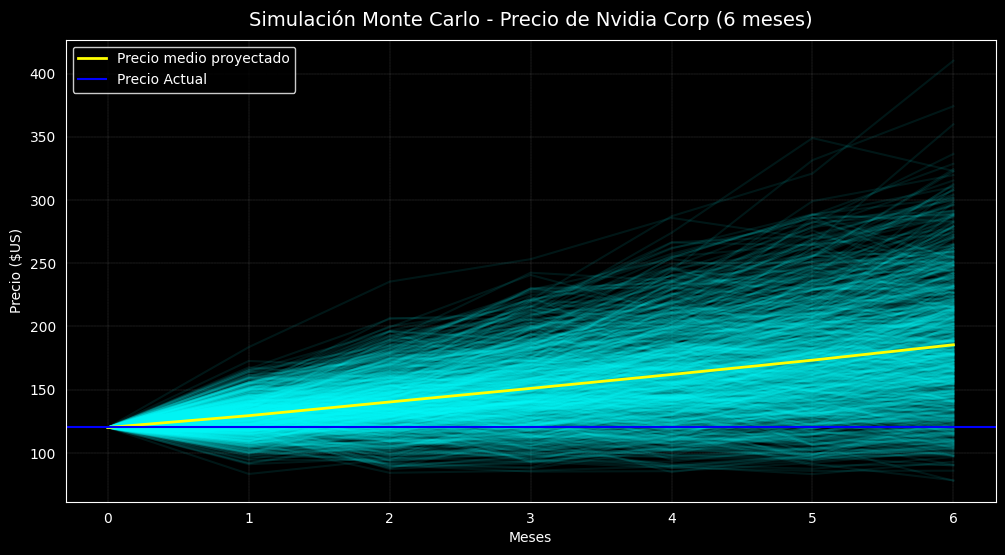

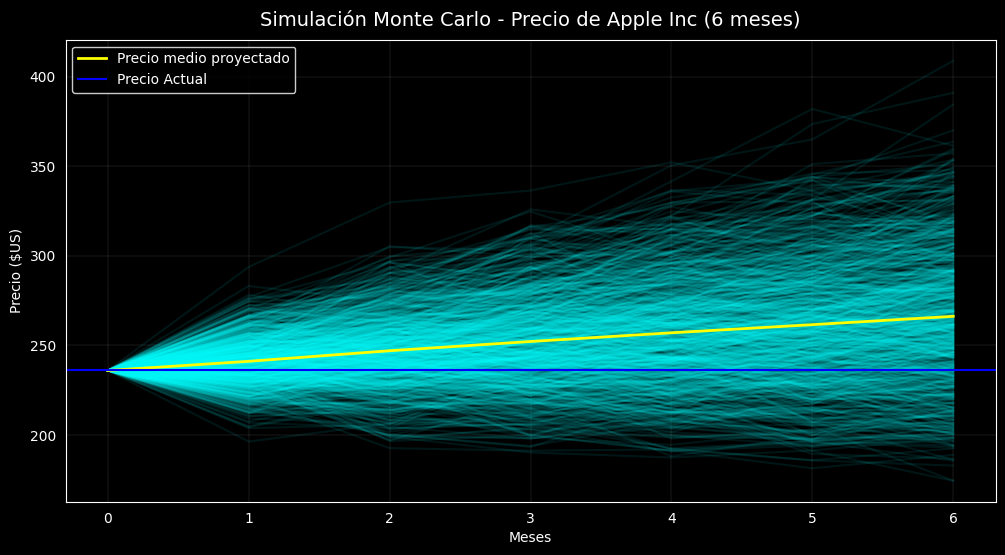

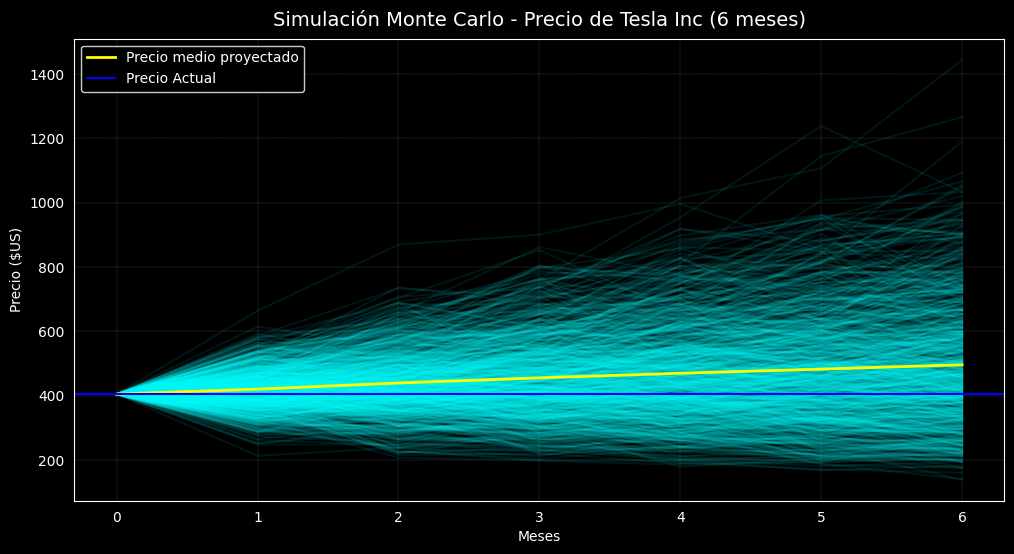

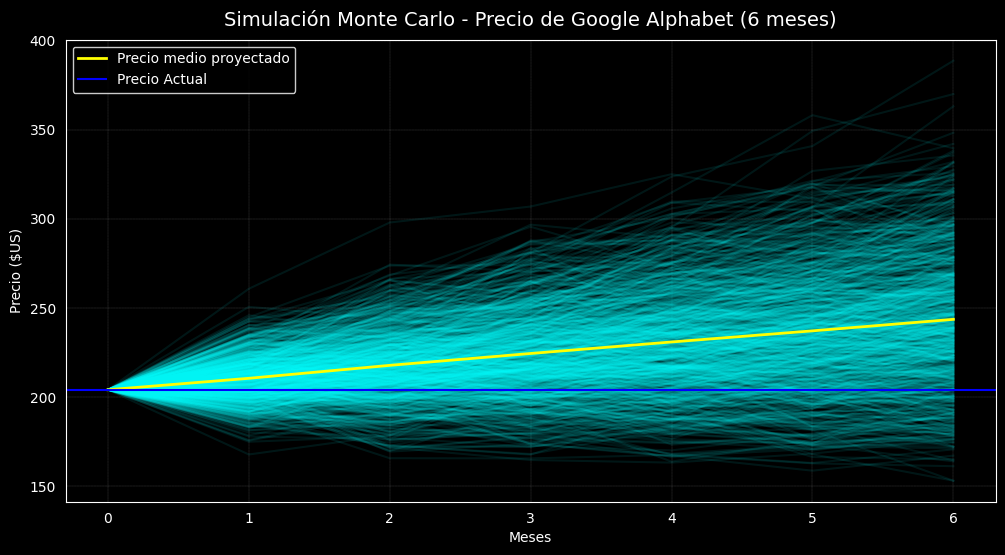

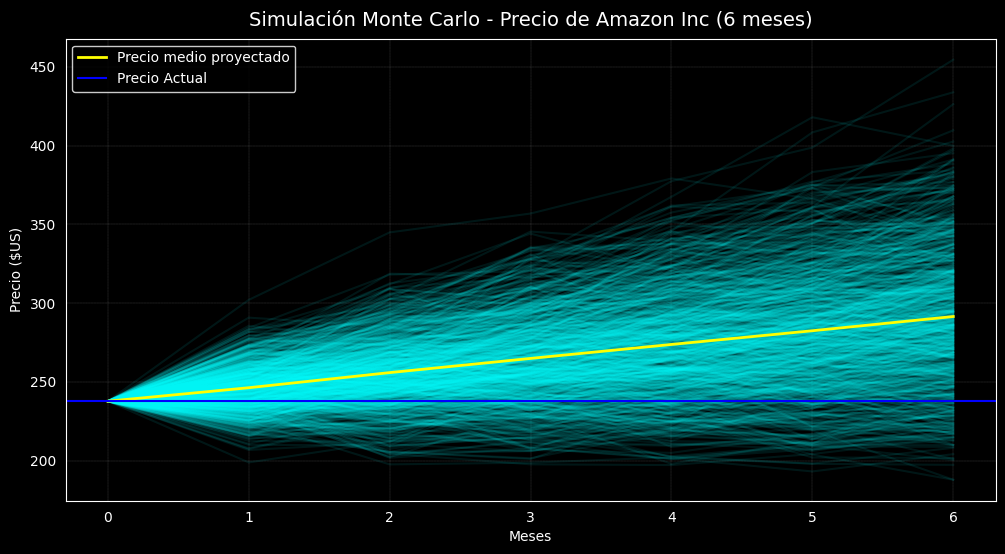

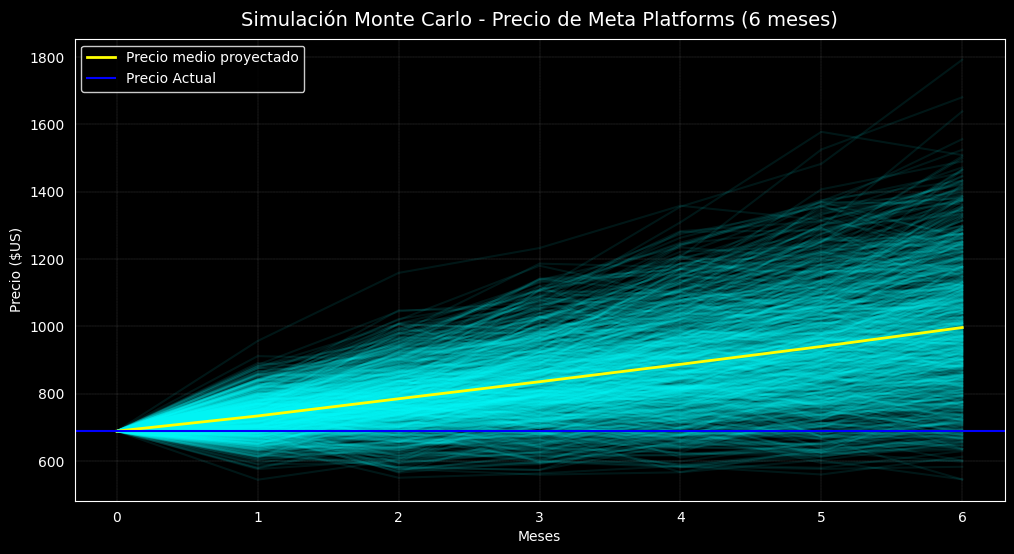

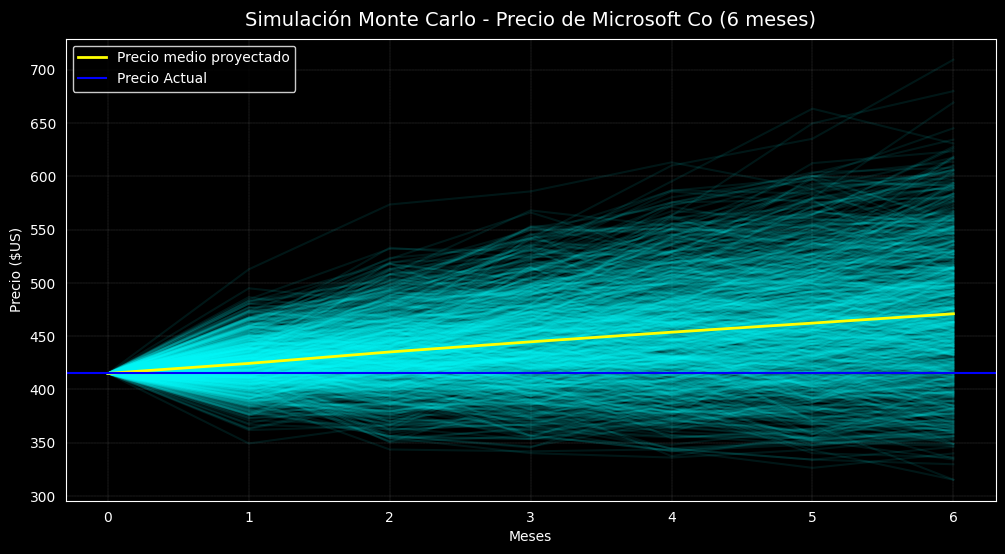

In [26]:
def obtener_parametros_empresa(nombre_empresa, resumen_resultados, df):
    empresa_fila = resumen_resultados[resumen_resultados['Empresa'] == nombre_empresa]
    
    if empresa_fila.empty:
        print(f"La empresa '{nombre_empresa}' no fue encontrada en el resumen.")
        return None
    
    retorno_medio = empresa_fila['Retorno Medio Mensual (%)'].values[0] / 100
    volatilidad = empresa_fila['Volatilidad Mensual (%)'].values[0] / 100
    nombre_empresa_columna = nombre_empresa.replace(' ', '_')
    precio_final = df[nombre_empresa_columna].iloc[-1]  # Último precio disponible
    
    parametros = {
        'retorno_medio': retorno_medio,
        'volatilidad': volatilidad,
        'precio_actual': precio_final
    }
    
    return parametros

# Lista de empresas a analizar
empresas = ['Nvidia Corp', 'Apple Inc', 'Tesla Inc', 'Google Alphabet', 'Amazon Inc', 'Meta Platforms', 'Microsoft Co']

# Parámetros de la simulación
meses = 6  # Número de meses para la simulación
simulaciones = 1000  # Número de simulaciones

# Crear un DataFrame para almacenar los resultados
resultados_monte_carlo = pd.DataFrame(columns=['Empresa', 'Precio Actual','Precio Promedio', 'Precio Mínimo', 'Precio Máximo'])

# Bucle para generar gráficos y almacenar resultados para cada empresa
for nombre_empresa in empresas:
    # Obtener los parámetros de la empresa
    parametros = obtener_parametros_empresa(nombre_empresa, resumen_resultados, data_original)
    
    if parametros:
        # Extraer los parámetros
        ultimo_precio = parametros['precio_actual']
        retorno_medio_mensual = parametros['retorno_medio']
        volatilidad_mensual = parametros['volatilidad']

        # Simulación Monte Carlo
        np.random.seed(42)  # Fijar la semilla para reproducibilidad
        precios = np.zeros((meses + 1, simulaciones))
        precios[0] = ultimo_precio

        for t in range(1, meses + 1):
            perturbacion = np.random.normal(retorno_medio_mensual, volatilidad_mensual, simulaciones)
            precios[t] = precios[t - 1] * (1 + perturbacion)

        # Calcular resultados
        precio_final_avg = precios[-1].mean()
        precio_minimo = precios[-1].min()
        precio_maximo = precios[-1].max()

        # graficos
        plt.figure(figsize=(12, 6))
        plt.plot(precios, color='cyan', alpha=0.09)
        plt.plot(precios.mean(axis=1), color='yellow', label='Precio medio proyectado', linewidth=2)
        plt.axhline(ultimo_precio, color='blue', label='Precio Actual')
        plt.xlabel('Meses', color='white')
        plt.ylabel('Precio ($US)', color='white')
        plt.title(f'Simulación Monte Carlo - Precio de {nombre_empresa} (6 meses)', color='white', fontsize=14, pad=10)
        plt.xticks(color='white')
        plt.yticks(color='white')
        plt.gca().set_facecolor('black')
        plt.gcf().set_facecolor('black')    
        plt.legend(loc= 'upper left', fontsize=10, facecolor='black', edgecolor='white', labelcolor='white')
        plt.grid(color='white', linestyle='--', linewidth=0.1)
        for ax in plt.gca().spines.values():
            ax.set_color('white')
        plt.show()
        
        
        # Crear un DataFrame temporal con los resultados de la empresa actual
        resultados_empresa = pd.DataFrame({
            'Empresa': [nombre_empresa],
            'Precio Actual': [ultimo_precio],   
            'Precio Promedio': [precio_final_avg],
            'Precio Mínimo': [precio_minimo],
            'Precio Máximo': [precio_maximo]
        })

        # Concatenar los resultados al DataFrame principal
        resultados_monte_carlo = pd.concat([resultados_monte_carlo, resultados_empresa.round(2)], ignore_index=True)


- Resumen de las simulaciones

In [27]:
resultados_monte_carlo

,Empresa,Precio Actual,Precio Promedio,Precio Mínimo,Precio Máximo
0,Nvidia Corp,120.07,185.49,77.97,410.14
1,Apple Inc,236.00,266.22,174.46,408.87
2,Tesla Inc,404.60,495.96,138.29,1444.93
3,Google Alphabet,204.02,243.55,152.92,388.79
4,Amazon Inc,237.68,291.44,187.84,454.46
5,Meta Platforms,689.18,996.93,545.43,1792.34
6,Microsoft Co,415.06,470.99,315.27,709.43


## <h1> 📊 Resultados y Conclusiones:<h1>

🎯 Este proyecto incluye un análisis más profundo con gráficos detallados, interpretaciones de los resultados y 2 escenarios más proyectados.
Si te interesa ver el análisis completo y el informe final ¡no dudes en contactarme!

📩 Correo: braulioherre98@gmail.com